# Gaussian Process Regression

This notebook, I will go over how we can implement the Gaussian process (GP) regression algorithm using Jax. This isn't a new algorithm or anything but I would like to get accustomed to using Jax because it will be useful later when I implement the GPs to handle uncertain inputs.

**Inspirations**

* [Github Code](https://github.com/lucasrm25/Structured-Learning-for-Robot-Control/blob/master/GP/jaxGP.py) - [Lucas](https://www.linkedin.com/in/lucas-rath/?originalSubdomain=bo)
> Broke down the GP function very nicely. Nice enough for me to follow.

## Imports

In [6]:
import sys
from pyprojroot import here
sys.path.append(str(here()))


import functools
from typing import Callable, Dict, Tuple
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
# sns.set_style('whitegrid')
# sns.set_context('talk')
sns.set_context(context="talk", font_scale=0.7)

import numpy as onp
import tqdm
from jax.experimental import optimizers

from src.models.jaxgp.data import get_data
from src.models.jaxgp.exact import predictive_mean, predictive_variance
from src.models.jaxgp.kernels import gram, rbf_kernel, ard_kernel
from src.models.jaxgp.loss import marginal_likelihood
from src.models.jaxgp.mean import zero_mean
from src.models.jaxgp.utils import cholesky_factorization, get_factorizations, saturate

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers
import numpy as np
import numpy as onp

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

## Data

In [13]:
from dataclasses import dataclass

@dataclass
class args:
    num_train = 30
    num_test = 1_000
    smoke_test = False
    input_noise = 0.15
    output_noise = 0.15

In [14]:
# sigma_inputs = 0.15
input_cov = jnp.array([args.input_noise]).reshape(-1, 1)
X, y, Xtest, ytest = get_data(
    N=args.num_train,
    input_noise=args.input_noise,
    output_noise=args.output_noise,
    N_test=args.num_test,
)

## Model

In [15]:
# PRIOR FUNCTIONS (mean, covariance)
mu_f = zero_mean
cov_f = functools.partial(gram, ard_kernel)
gp_priors = (mu_f, cov_f)

# Kernel, Likelihood parameters
params = {
    # "gamma": 2.0,
    "length_scale": 1.0,
    "var_f": 1.0,
    "likelihood_noise": 1.0,
}
# saturate parameters with likelihoods
params = saturate(params)

# LOSS FUNCTION
mll_loss = jax.jit(functools.partial(marginal_likelihood, gp_priors))

# GRADIENT LOSS FUNCTION
dloss = jax.jit(jax.grad(mll_loss))

## Optimizer

In [16]:
# STEP FUNCTION
@jax.jit
def step(params, X, y, opt_state):
    # calculate loss
    loss = mll_loss(params, X, y)

    # calculate gradient of loss
    grads = dloss(params, X, y)

    # update optimizer state
    opt_state = opt_update(0, grads, opt_state)

    # update params
    params = get_params(opt_state)

    return params, opt_state, loss

## Training

In [17]:
# TRAINING PARARMETERS
n_epochs = 500 if not args.smoke_test else 2
learning_rate = 0.01
losses = list()

# initialize optimizer
opt_init, opt_update, get_params = optimizers.rmsprop(step_size=learning_rate)

# initialize parameters
opt_state = opt_init(params)

# get initial parameters
params = get_params(opt_state)

postfix = {}

with tqdm.trange(n_epochs) as bar:

    for i in bar:
        # 1 step - optimize function
        params, opt_state, value = step(params, X, y, opt_state)

        # update params
        postfix = {}
        for ikey in params.keys():
            postfix[ikey] = f"{jax.nn.softplus(params[ikey]):.2f}"

        # save loss values
        losses.append(value.mean())

        # update progress bar
        postfix["Loss"] = f"{onp.array(losses[-1]):.2f}"
        bar.set_postfix(postfix)
        # saturate params
        params = saturate(params)

100%|██████████| 500/500 [00:07<00:00, 71.09it/s, length_scale=1.20, likelihood_noise=0.16, var_f=1.07, Loss=21.34]


## Predictions

In [19]:
# Posterior Predictions
mu_y = predictive_mean(params, gp_priors, X, y, Xtest)
var_y = predictive_variance(params, gp_priors, X, y, Xtest, True, False)

# Uncertainty
uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())

## Results

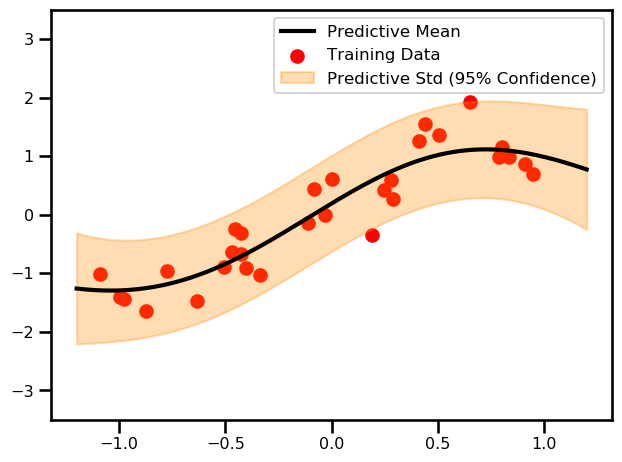

In [20]:
fig, ax = plt.subplots()

ax.scatter(X, y, c="red", label="Training Data")
ax.plot(
    Xtest.squeeze(),
    mu_y.squeeze(),
    label=r"Predictive Mean",
    color="black",
    linewidth=3,
)
ax.fill_between(
    Xtest.squeeze(),
    mu_y.squeeze() + uncertainty,
    mu_y.squeeze() - uncertainty,
    alpha=0.3,
    color="darkorange",
    label=f"Predictive Std (95% Confidence)",
)
ax.set_ylim([-3.5, 3.5])
ax.legend(fontsize=12)

plt.tight_layout()
# fig.savefig("figures/jaxgp/examples/taylor/1d_gp.png")
plt.show()

#### Jax

In [184]:
# checks - 1 vector (D)
params = {
    'length_scale': 0.1, 
    'var_f': 1.0, 
}


n_samples = 10                   # condition on 3 samples 
test_X = X[:n_samples, :].copy() # random samples from distribution

mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f , x=test_X)

# make it semi-positive definite with jitter
jitter = 1e-6
cov_x_ = cov_x + jitter * jnp.eye(cov_x.shape[0])


n_functions = 10

key = jax.random.PRNGKey(0)

y_samples = jax.random.multivariate_normal(key, mu_x, cov_x_, shape=(n_functions,))

# check
assert y_samples.shape == (n_functions, n_samples)

for isample in y_samples:
    plt.plot(isample)

KeyError: 'gamma'